In [1]:
%load_ext autoreload
%autoreload 2

from resource import *

%matplotlib inline
plt.style.use('dark_background')

1. Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log (как вариант - использовать np.clip или np.where).

In [2]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype=np.float64).T

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype=np.float64)

In [3]:
def calc_logloss(y, y_pred):
    y_pred_clipped = np.where(y_pred == 0, 1e-15, np.where(y_pred == 1, 1 - 1e-15, y_pred))
    # y_pred_clipped = np.clip(y_pred, 1e-15, 1 - 1e-15)
    # err = np.mean(-y * np.log(y_pred + 1e-15) - (1.0 - y) * np.log(1.0 - y_pred + 1e-15))
    err = np.mean(-y * np.log(y_pred_clipped) - (1.0 - y) * np.log(1.0 - y_pred_clipped))
    return err

In [4]:
# Пример применения
y_true = 0
y_pred = 1
calc_logloss(y_true, y_pred)

34.53957599234088

2. На данных из урока изучите влияние гиперпараметров на ошибку алгоритма. Подберите аргументы функции eval_LR_model для логистической регрессии таким образом, чтобы log loss не превышал значение 0.3 (0.1). Как изменились веса?

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [6]:
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[:, 2] = scaler.fit_transform(X_scaled[:, 2])
X_scaled[:, 2]

array([-0.97958969, -0.56713087, -0.46401617, -0.77336028,  0.97958969,
       -0.36090146,  1.08270439,  2.11385144, -1.08270439,  0.05155735])

In [7]:
def calc_gradient(samples, targets, yhat):
    return 2 * (yhat - targets) @ samples / samples.shape[0]

def predict(samples, weight):
    return samples @ weight

def update(samples, targets, yhat, weight, alpha):
    return weight - alpha * calc_gradient(samples, targets, yhat)

In [8]:
def eval_lr_model(samples, targets, iterations, alpha=1e-3, min_los=1, print_cost=True):
    np.random.seed(42)
    w = np.random.randn(samples.shape[1])
    loss = calc_logloss(targets, sigmoid(np.dot(samples, w)))
    for i in range(1, iterations + 1):
        yhat = sigmoid(predict(samples, w))
        new_weight = update(samples, targets, yhat, w, alpha)
        loss = calc_logloss(targets, sigmoid(np.dot(samples, new_weight)))
        if i < iterations and loss < min_los:
            print(f'Model iterations: {i}, loss: {loss}, weight={w} ...')
            break
        if print_cost == True and i % 100 == 0:
            print(i, w, loss)
        w = new_weight
    return w, loss

In [9]:
eval_lr_model(X_scaled, y, iterations=1000, alpha=1, min_los=0.3, print_cost=True)

100 [-4.93512183 -0.27160891 -0.11835431  6.59492325] 1.23432503325964
Model iterations: 151, loss: 0.29944149711205514, weight=[-7.80817012 -1.5183843  -0.74699779  7.3319981 ] ...


(array([-7.80817012, -1.5183843 , -0.74699779,  7.3319981 ]),
 0.29944149711205514)

In [10]:
eval_lr_model(X_scaled, y, iterations=10000, alpha=1, min_los=0.1, print_cost=True)

100 [-4.93512183 -0.27160891 -0.11835431  6.59492325] 1.23432503325964
200 [-8.18720769 -1.05100497 -1.38340955  8.96806899] 1.3523364339574155
300 [-10.87310042  -1.7398129   -2.19145519   9.25699022] 0.26645782813403157
400 [-12.10337872  -1.77533439  -2.57895763  10.22992917] 0.2510543069728562
500 [-13.22441149  -1.81729246  -2.94121175  11.11077753] 0.2387631620297978
600 [-14.26080562  -1.85894107  -3.27157134  11.92983339] 0.22822782066885033
700 [-15.22830907  -1.89854516  -3.57680676  12.69777238] 0.21899154727697406
800 [-16.13696825  -1.93452009  -3.86096565  13.42258182] 0.2107733406994703
900 [-16.99314126  -1.96451023  -4.12628888  14.11222864] 0.2034391112104028
1000 [-17.80262577  -2.00499038  -4.37290107  14.77419966] 0.197356743469764
1100 [-18.5791518   -2.07127072  -4.60511659  15.40448605] 0.1920682462122951
1200 [-19.32463112  -2.13612009  -4.82710858  16.00939239] 0.1871967995027222
1300 [-20.04144569  -2.19864055  -5.03995461  16.59102326] 0.18269393442296059
14

(array([-43.12422716,  -4.21733156, -11.72274232,  35.19008921]),
 0.09999999367728905)

In [11]:
class LogisticRegression(ElasticGradientLinearRegression):

    def loss(self):
        eps = 1e-15
        yhat = self.predict()

        l1_term = self.l1_penalty * np.sum(self.weight[1:])
        l2_term = (self.l2_penalty / 2) * np.sum(np.square(self.weight[1:]))

        y_hat_clipped = np.where(yhat == 0, eps, np.where(yhat == 1, 1 - eps, yhat))
        
        loss = np.mean(-(self.targets * np.log(y_hat_clipped) + (1 - self.targets) * np.log(
            1 - y_hat_clipped))) + l1_term + l2_term
        return loss

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    def predict(self):
        return self.sigmoid(self.samples @ self.weight)



Cost at iteration 100 is 0.3847727258568115, weight=[-5.62958334 -1.43240532 -0.40271308  5.16232862]
Model alpha: 1.0, diff_mse: 1e-15, iterations: 154, loss: 0.298791709575928 ...


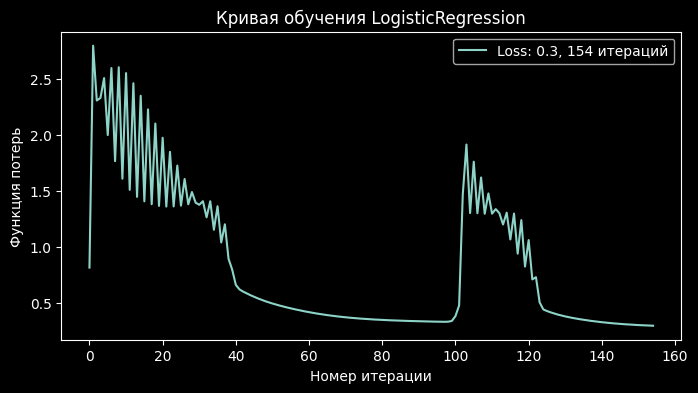

CPU times: total: 406 ms
Wall time: 426 ms


array([-7.94302154, -1.52977087, -0.78904514,  7.44037246])

In [12]:
%%time
log_regressor = LogisticRegression(samples=X_scaled, targets=y,
                                   alpha=1e-0, diff_mse=1e-15, min_los=0.3,
                                   print_cost=True, fit_intercept=False,
                                   l1_penalty=0.00, l2_penalty=0.00)
log_l = log_regressor.fit()
log_w = log_regressor.get_weights()
plot_learning_curves(model=log_regressor)
log_w

Cost at iteration 100 is 0.3847727258568115, weight=[-5.62958334 -1.43240532 -0.40271308  5.16232862]
Cost at iteration 200 is 0.2801415297502827, weight=[-8.81438442 -1.28798186 -1.56788511  7.58430611]
Cost at iteration 300 is 0.2620587463851519, weight=[-10.88256898  -1.36506498  -2.2369754    9.27014799]
Cost at iteration 400 is 0.25110727775377184, weight=[-12.03992095  -1.52396305  -2.55509204  10.35935382]
Cost at iteration 500 is 0.23880771075866297, weight=[-13.17232981  -1.60436245  -2.92094045  11.21932397]
Cost at iteration 600 is 0.22826651429939543, weight=[-14.21920837  -1.68260755  -3.2548686   12.01916694]
Cost at iteration 700 is 0.21902575861342782, weight=[-15.1969902   -1.75931947  -3.563814    12.76824779]
Cost at iteration 800 is 0.21080394546569195, weight=[-16.11658149  -1.83616615  -3.85214817  13.47295887]
Cost at iteration 900 is 0.2034659935248127, weight=[-16.98613381  -1.91795131  -4.12287429  14.13798473]
Cost at iteration 1000 is 0.19737847428671462, we

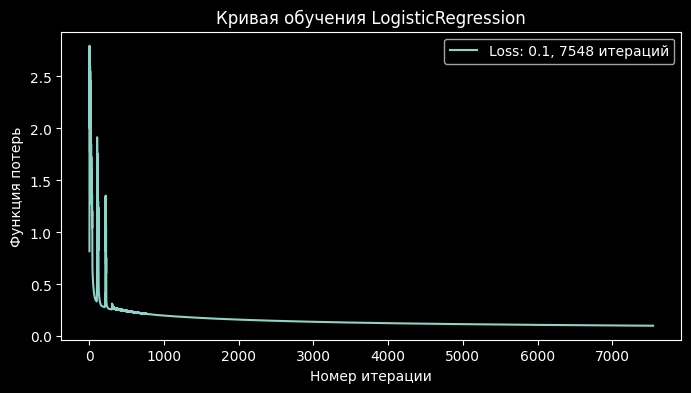

CPU times: total: 3.03 s
Wall time: 3 s


array([-43.12788703,  -4.21764123, -11.72379488,  35.1930016 ])

In [13]:
%%time
log_regressor = LogisticRegression(samples=X_scaled, targets=y,
                                   alpha=1e-0, diff_mse=1e-15, min_los=0.1,
                                   print_cost=True, fit_intercept=False,
                                   l1_penalty=0.00, l2_penalty=0.00)
log_l = log_regressor.fit()
log_w = log_regressor.get_weights()
plot_learning_curves(model=log_regressor)
log_w